In [1]:
import torch 
from pathlib import Path
from src.data.dataloader import ImageCaptionDataset
from torchtext.transforms import Sequential, AddToken, Truncate, ToTensor, VocabTransform
from src.models.train_model import vocabulary, MAX_SEQ_LEN, tokenizer, collate_function
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from src.utils import get_text_for_batch
tokenizer = get_tokenizer('basic_english')
checkpoint_path = Path.cwd().joinpath("checkpoints",
                                      "lstm-8-layers-without-beam",
                                      "BEST_checkpoint_images-captioning.pth.tar")


text_tranform = Sequential(VocabTransform(vocabulary),
                           Truncate(max_seq_len=MAX_SEQ_LEN - 2),
                           ToTensor())
data_path = Path.cwd().joinpath("data", "raw")
caption_prediction_path = Path.cwd().joinpath("data", "raw", "caption-prediction")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
validation_dataset = ImageCaptionDataset(caption_path=caption_prediction_path.joinpath("validation-captions.csv"),
                                         images_dir=data_path.joinpath("validation-images"),
                                         sequence_length=200,
                                         text_tokenizer=tokenizer,
                                         text_transform=text_tranform)

checkpoint = torch.load(checkpoint_path, map_location=device)
start_epoch = checkpoint['epoch'] + 1
epochs_since_improvement = checkpoint['epochs_since_improvement']
best_bleu4 = checkpoint['bleu-4']
decoder = checkpoint['decoder']
decoder_optimizer = checkpoint['decoder_optimizer']
encoder = checkpoint['encoder']
encoder_optimizer = checkpoint['encoder_optimizer']

decoder = decoder.to(device)
encoder = encoder.to(device)


#### Loading the training data

Let us load some training data.

In [3]:


validation_subset = torch.utils.data.Subset(validation_dataset, list(range(10, 21)))
validation_dataloader = DataLoader(validation_subset, batch_size=1, shuffle=False, collate_fn=collate_function)

10
this is the assigment code


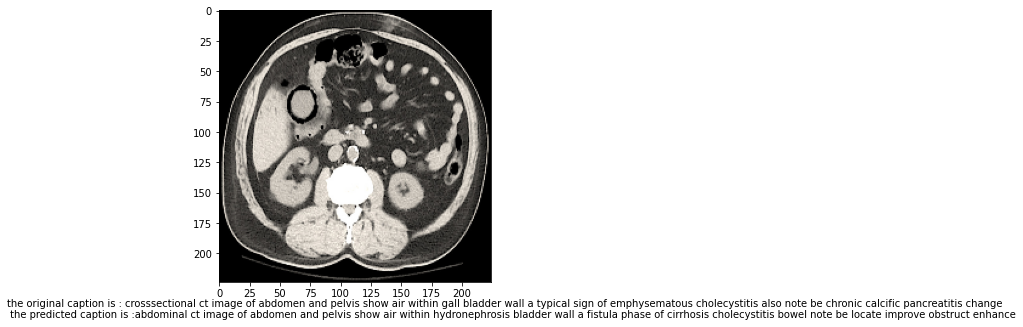

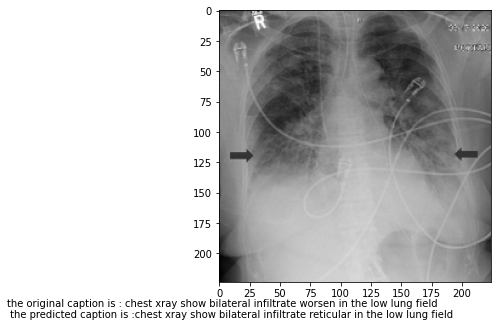

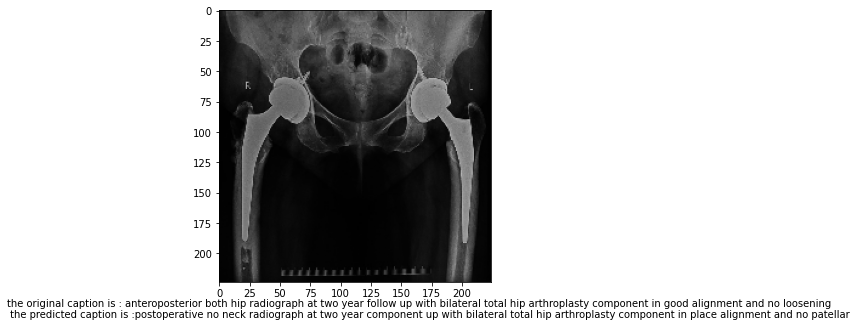

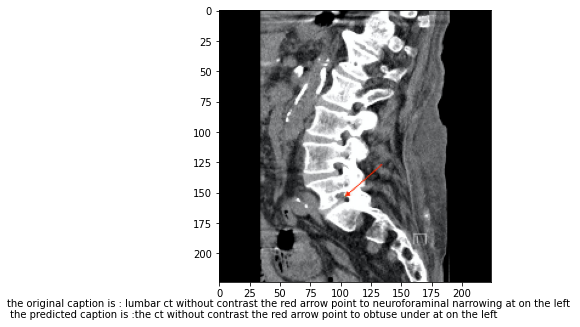

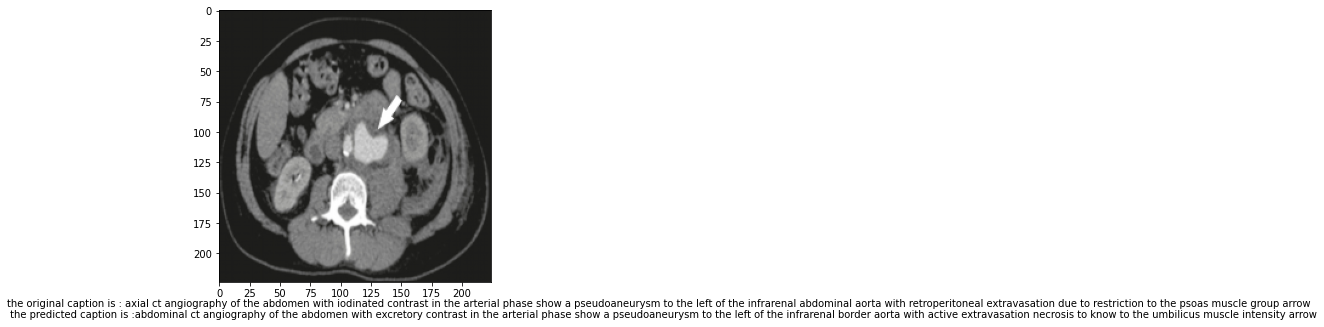

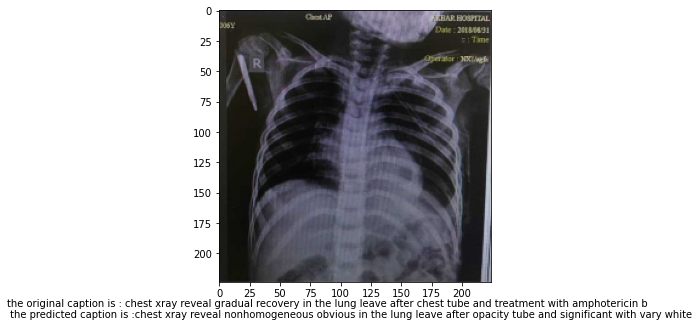

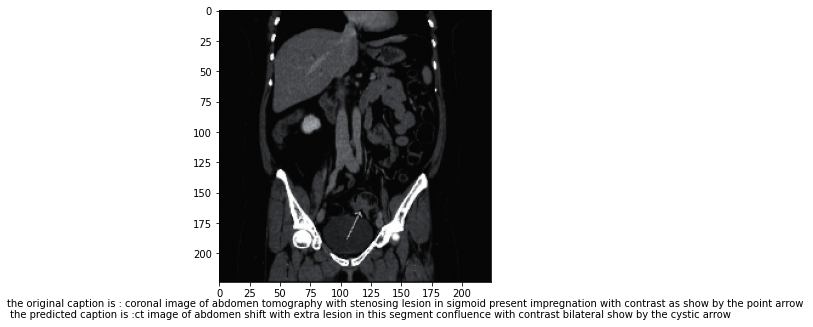

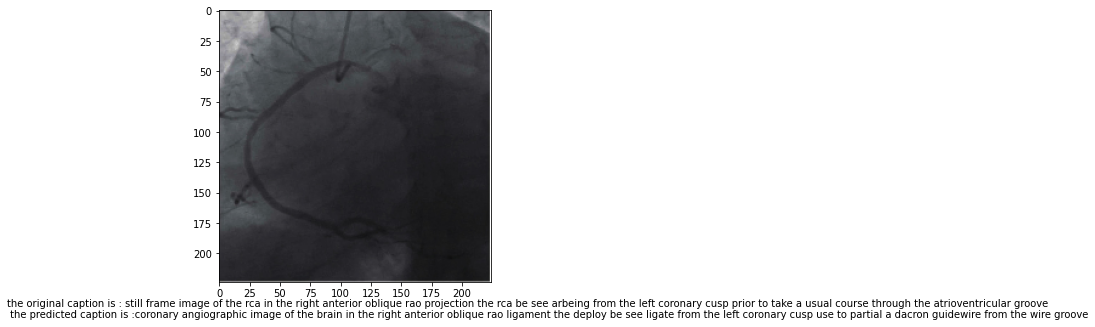

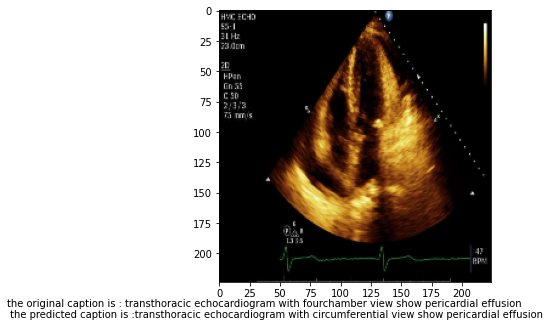

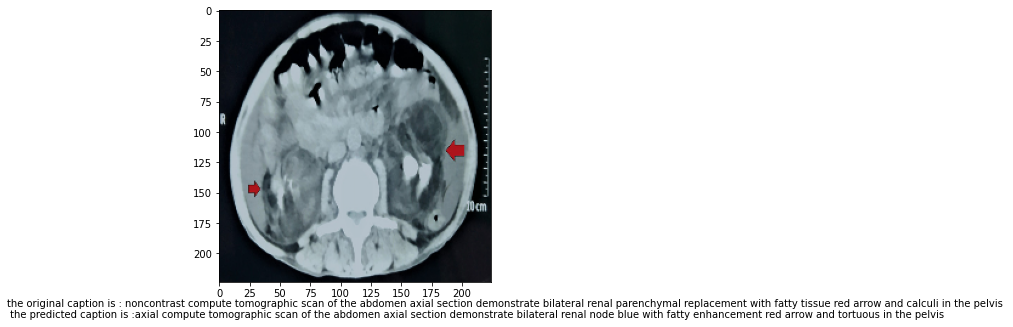

In [24]:
import matplotlib.pyplot as plt
import textwrap
wrapper = textwrap.TextWrapper(width=50)
decoder_layers = 8
print(len(iter(validation_dataloader)))
with torch.no_grad():
    # Batches
    print("this is the assigment code")
    for i, (images, captions, lengths) in enumerate(iter(validation_dataloader)):
        images = images.to(device)
        captions = captions.to(device)
        features = encoder(images)  # batch size x hidden size or (512
        features = features.expand(decoder_layers, features.shape[0], features.shape[1]) # (number of layer X batch size X hidden size)
        # Set the initial hidden state of the decoder to be the output of the encoder
        decoder_hidden = (features.contiguous(), features.contiguous())
        outputs = decoder(captions, decoder_hidden)
        predicted_indices = outputs.argmax(dim=1)
        caption_text = get_text_for_batch(captions, vocabulary, lengths)
        caption_text = " ".join(caption_text[0])
        predicted_text = get_text_for_batch(predicted_indices, vocabulary, lengths)
        predicted_text = " ".join(predicted_text[0])
        figure = plt.figure(figsize=(10, 5))
        plt.imshow(images[0].permute(1, 2, 0))
        caption = f'the original caption is : {caption_text} \n the predicted caption is :{predicted_text}'
        text = wrapper.fill(caption_text)
        word_list = wrapper.wrap(text=value)
        figure.text(.03, .03, 
                    text,
                    wrap=True)
        plt.show()